In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.spatial import KDTree

import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

Pick an arbitrary $\delta$ value.

In [3]:
delta = 0.01

Function to calculate the privacy metrics given training and synthetic data, for a given delta value.

In [4]:
def privacy_metrics(train_data, synthetic_datasets, type_of_synthetic, delta):

    # create scaler
    scaler = StandardScaler()

    # scale training data
    train_scaled = scaler.fit_transform(X=train_data)

    # create tree for nearest neighbor searching
    training_tree = KDTree(train_scaled)

    # calculate nearest neighbor distances within training data
    train_dists, train_neighbors = training_tree.query(x=train_scaled, k=6, p=2)

    # calculate identical match share
    # using the second column because we know there is at least one identical record (the record itself)
    # so we care about the next most similar record (the second nearest neighbor)
    IMS_train = np.mean(train_dists[:,1] <= delta)

    # calculate 5th percentile of DCR distribution for synthetic and train data
    DCR_train = np.percentile(train_dists[:,1], q=5)

    # calculate nearest neighbor distance ratios
    ratios_train = train_dists[:,1]/train_dists[:,-1]

    # we can encounter division by zero in the above ratios. If this occurs, neighbors 1-5 have the same distance (0)
    # and the ratio can be set to one.
    ratios_train = np.nan_to_num(ratios_train, nan=1.0)

    # calculate 5th percentile of nearest neighbor distance ratios
    NNDR_train = np.percentile(ratios_train, q=5)

    IMS_synthetic, DCR_synthetic, NNDR_synthetic = [], [], []
    
    for Z in synthetic_datasets:
        
        # create scaler
        scaler = StandardScaler()
        
        # scale synthetic data using means and standard deviations 
        synthetic_scaled = scaler.fit(X=train_data).transform(X=Z)

        # calculate the nearest neighbor distances between synthetic and training data
        synthetic_dists, synthetic_neighbors = training_tree.query(x=synthetic_scaled, k=5, p=2)

        # calculate identical match share
        IMS_synthetic.append(np.mean(synthetic_dists[:,0] <= delta))

        # calculate 5th percentile of DCR distribution for synthetic and train data
        DCR_synthetic.append(np.percentile(synthetic_dists[:,0], q=5))

        # calculate nearest neighbor distance ratios
        ratios_synthetic = synthetic_dists[:,0]/synthetic_dists[:,-1]

        # we can encounter division by zero in the above ratios. If this occurs, neighbors 1-5 have the same distance (0)
        # and the ratio can be set to one.
        ratios_synthetic = np.nan_to_num(ratios_synthetic, nan=1.0)

        # calculate 5th percentile of nearest neighbor distance ratios
        NNDR_synthetic.append(np.percentile(ratios_synthetic, q=5))

    return (pd.DataFrame({"Type" : np.concatenate([["Train"], np.repeat(type_of_synthetic, 20)]), 
                         "IMS" : np.concatenate([[IMS_train], IMS_synthetic]), 
                         "DCR" : np.concatenate([[DCR_train], DCR_synthetic]), 
                         "NNDR" : np.concatenate([[NNDR_train], NNDR_synthetic])}))
    
    # return ({"IMS_train": IMS_train, "IMS_synthetic": IMS_synthetic,
    #          "DCR_train": DCR_train, "DCR_synthetic": DCR_synthetic,
    #          "NNDR_train": NNDR_train, "NNDR_synthetic": NNDR_synthetic})

In [5]:
sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
sXs_mostly = [pd.read_csv("../Data/SK/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(20)]

In [6]:
pms_mnl = privacy_metrics(train_data=train, synthetic_datasets=sXs_mnl, type_of_synthetic="MNL", delta=delta)

C:\Users\cdbale\AppData\Local\Temp\ipykernel_38700\3563732218.py:24: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [7]:
pms_cart = privacy_metrics(train_data=train, synthetic_datasets=sXs_cart, type_of_synthetic="CART", delta=delta)

C:\Users\cdbale\AppData\Local\Temp\ipykernel_38700\3563732218.py:24: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [8]:
pms_mostly = privacy_metrics(train_data=train, synthetic_datasets=sXs_mostly, type_of_synthetic="MOSTLY.AI", delta=delta)

C:\Users\cdbale\AppData\Local\Temp\ipykernel_38700\3563732218.py:24: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [9]:
privacy_results = pd.concat([pms_mnl, pms_cart.iloc[1:,:], pms_mostly.iloc[1:,:]]).reset_index(drop=True)

In [10]:
privacy_results = privacy_results.melt(id_vars=["Type"], value_vars=["IMS", "DCR", "NNDR"], var_name="Metric") 

In [11]:
privacy_results.to_csv("../Results/SK/privacy_metrics.csv", index=False)

***

Examine how IMS diff changes with $\delta$

In [12]:
def ims_calc(train_data, synthetic_data, delta, synthetic_is_train=False):
    
    scaler = StandardScaler()
    
    train_data_scaled = scaler.fit_transform(X=train_data)
    
    training_tree = KDTree(train_data_scaled)
    
    synthetic_data_scaled = scaler.fit(X=train_data).transform(X=synthetic_data)
    
    synthetic_dists, synthetic_neighbors = training_tree.query(x=synthetic_data_scaled, k=2, p=2)

    if synthetic_is_train:
        IMS_synthetic = np.mean(synthetic_dists[:,1] <= delta)
    else:
        IMS_synthetic = np.mean(synthetic_dists[:,0] <= delta)
    
    return IMS_synthetic

In [13]:
def ims_apply(train_data, synthetic_data_sets, delta_vals, synthetic_is_train=False):
    ims = [[ims_calc(train_data=train_data, synthetic_data=y, delta=x, synthetic_is_train=synthetic_is_train) for x in delta_vals] for y in synthetic_data_sets]
    if synthetic_is_train:
        return ims
    else:
        avg_ims = np.mean(np.vstack(ims), axis=0)
        return avg_ims

In [21]:
delta_vals = np.linspace(0.00001, 1.0, 40)

In [23]:
train_ims = ims_apply(train, [train], delta_vals, synthetic_is_train=True)
avg_mnl_ims = ims_apply(train, sXs_mnl, delta_vals)
avg_cart_ims = ims_apply(train, sXs_cart, delta_vals)
avg_mostly_ims = ims_apply(train, sXs_mostly, delta_vals)

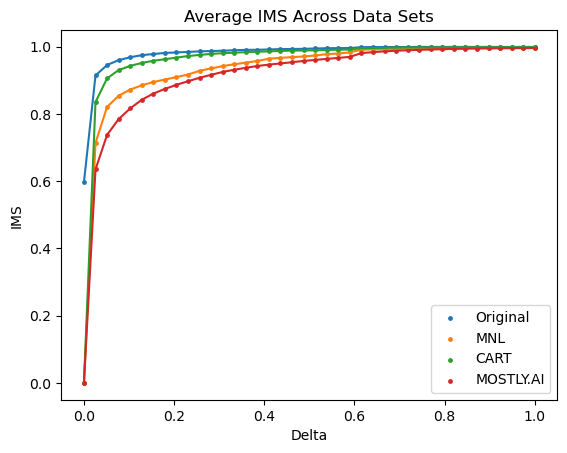

In [32]:
plt.plot(delta_vals, train_ims[0])
plt.scatter(delta_vals, train_ims, s=6, label="Original")

plt.plot(delta_vals, avg_mnl_ims)
plt.scatter(delta_vals, avg_mnl_ims, s=6, label="MNL")

plt.plot(delta_vals, avg_cart_ims)
plt.scatter(delta_vals, avg_cart_ims, s=6, label="CART")

plt.plot(delta_vals, avg_mostly_ims)
plt.scatter(delta_vals, avg_mostly_ims, s=6, label="MOSTLY.AI")

plt.title("Average IMS Across Data Sets")
plt.xlabel("Delta")
plt.ylabel("IMS")

plt.legend()
plt.show()

***

Assess attribute disclosure for disease status.

Let's start with the adversary's prior. As of March 23, 2020, their were 9583 confirmed COVID-19 cases and 152 deaths. 

https://covid19.who.int/region/wpro/country/kr

These statistics could be collected from the World Health Organization, and would represent a much more informative prior than a naive uniform prior. Furthermore, evaluating the naive prior would create problems when trying to prevent inference on individuals who did not pass away from COVID.

In [15]:
prior_death_prob = 152/9583

In [16]:
def inference_evaluation(original_data, synthetic_data, prior_prob, deltas):
    
    full_inf_conds = []
    full_indices = []
    
    # tree for original locations
    orig_tree = KDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = KDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the inference condition for each original row and the indices of those rows that violate
        inf_conds = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age']] == row[['sex', 'age']]).all(1)
            
            matching_rows = synthetic_data.loc[location_neighbors[i],:].loc[categorical_matches.values,:]
            
            if matching_rows.shape[0] > 0:
                
                if row['state'] == 1.0:
                    prior = prior_prob
                else:
                    prior = 1 - prior_prob
            
                cond = np.mean(matching_rows['state'] == row['state'])/prior
                
            else:
                
                cond = 1
        
            # store number of matches and their indices
            inf_conds.append(cond)
        
        inf_conds = pd.Series(inf_conds)
        
        full_inf_conds.append(inf_conds)
        
    print("Dataset completed.")
        
    return full_inf_conds

In [17]:
holdout_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in holdout_datasets]
holdout_inf = [pd.concat(x, axis=1) for x in holdout_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [18]:
for i in range(20):
    holdout_inf[i].to_csv("Data/privacy_results/holdout_inf_" + str(i) + ".csv", index=False)
holdout_inf = [pd.read_csv("Data/privacy_results/holdout_inf_" + str(i) + ".csv") for i in range(20)]

In [19]:
mnl_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_logit_pmse]
mnl_inf = [pd.concat(x, axis=1) for x in mnl_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [20]:
for i in range(20):
    mnl_inf[i].to_csv("Data/privacy_results/mnl_inf_" + str(i) + ".csv", index=False)
mnl_inf = [pd.read_csv("Data/privacy_results/mnl_inf_" + str(i) + ".csv") for i in range(20)]

In [21]:
mnl_inf_prev = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_logit_inf_pmse]
mnl_inf_prev = [pd.concat(x, axis=1) for x in mnl_inf_prev]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [22]:
for i in range(20):
    mnl_inf_prev[i].to_csv("Data/privacy_results/mnl_inf_prev_" + str(i) + ".csv", index=False)
mnl_inf_prev = [pd.read_csv("Data/privacy_results/mnl_inf_prev_" + str(i) + ".csv") for i in range(20)]

In [23]:
cart_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_cart_mb_pmse]
cart_inf = [pd.concat(x, axis=1) for x in cart_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [24]:
for i in range(20):
    cart_inf[i].to_csv("Data/privacy_results/cart_inf_" + str(i) + ".csv", index=False)
cart_inf = [pd.read_csv("Data/privacy_results/cart_inf_" + str(i) + ".csv") for i in range(20)]

In [25]:
cart_inf_prev = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_cart_mb_inf_pmse]
cart_inf_prev = [pd.concat(x, axis=1) for x in cart_inf_prev]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [26]:
for i in range(20):
    cart_inf_prev[i].to_csv("Data/privacy_results/cart_inf_prev_" + str(i) + ".csv", index=False)
cart_inf_prev = [pd.read_csv("Data/privacy_results/cart_inf_prev_" + str(i) + ".csv") for i in range(20)]

In [27]:
mostly_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_mostly]
mostly_inf = [pd.concat(x, axis=1) for x in mostly_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [28]:
for i in range(20):
    mostly_inf[i].to_csv("Data/privacy_results/mostly_inf_" + str(i) + ".csv", index=False)
mostly_inf = [pd.read_csv("Data/privacy_results/mostly_inf_" + str(i) + ".csv") for i in range(20)]

Need to calculate the maximum increase in inference in each data set.

In [29]:
max_holdout_inf = [np.max(x, axis=0) for x in holdout_inf]
max_mnl_inf = [np.max(x, axis=0) for x in mnl_inf]
max_mnl_inf_prev = [np.max(x, axis=0) for x in mnl_inf_prev]
max_cart_inf = [np.max(x, axis=0) for x in cart_inf]
max_cart_inf_prev = [np.max(x, axis=0) for x in cart_inf_prev]
max_mostly_inf = [np.max(x, axis=0) for x in mostly_inf]

Could look at the distribution of the maximum increase for each data set.

In [30]:
avg_max_holdout = np.mean(pd.concat(max_holdout_inf, axis=1), axis=1)
avg_max_mnl = np.mean(pd.concat(max_mnl_inf, axis=1), axis=1)
avg_max_mnl_prev = np.mean(pd.concat(max_mnl_inf_prev, axis=1), axis=1)
avg_max_cart = np.mean(pd.concat(max_cart_inf, axis=1), axis=1)
avg_max_cart_prev = np.mean(pd.concat(max_cart_inf_prev, axis=1), axis=1)
avg_max_mostly = np.mean(pd.concat(max_mostly_inf, axis=1), axis=1)

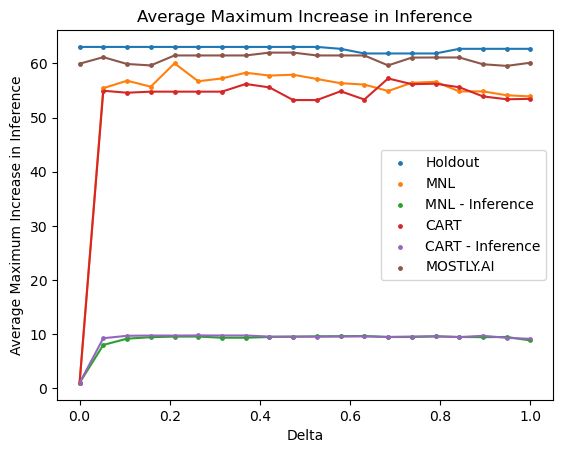

In [31]:
plt.plot(delta_vals, avg_max_holdout)
plt.scatter(delta_vals, avg_max_holdout, s=6, label="Holdout")

plt.plot(delta_vals, avg_max_mnl)
plt.scatter(delta_vals, avg_max_mnl, s=6, label="MNL")

plt.plot(delta_vals, avg_max_mnl_prev)
plt.scatter(delta_vals, avg_max_mnl_prev, s=6, label="MNL - Inference")

plt.plot(delta_vals, avg_max_cart)
plt.scatter(delta_vals, avg_max_cart, s=6, label="CART")

plt.plot(delta_vals, avg_max_cart_prev)
plt.scatter(delta_vals, avg_max_cart_prev, s=6, label="CART - Inference")

plt.plot(delta_vals, avg_max_mostly)
plt.scatter(delta_vals, avg_max_mostly, s=6, label="MOSTLY.AI")

plt.title("Average Maximum Increase in Inference")
plt.xlabel("Delta")
plt.ylabel("Average Maximum Increase in Inference")

plt.legend()
plt.show()